## Use Case
A client has data on users for an application from the past two years. They define an "adopted user" as a user who has logged into the application on three separate days in at least one seven ­day period. They want to understand what variables contribute to a user converting into an adopted user. The assignment is to inspect the data and prepare an analysis that shows non-technical stakeholders what variables and conditions are associated with user adoption.

A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:
● name: the user's name
● object_id: the user's id
● email: email address
● creation_source: how their account was created. This takes on one of 5 values:

        ○  PERSONAL_PROJECTS: invited to join another user's personal workspace
        ○  GUEST_INVITE: invited to an organization as a guest (limited permissions)            
        ○  ORG_INVITE: invited to an organization (as a full member)            
        ○  SIGNUP: signed up via the website
        ○  SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)                                                                              
● creation_time: when they created their account
● last_session_creation_time: unix timestamp of last login
● opted_in_to_mailing_list: whether they have opted into receiving marketing emails

● enabled_for_marketing_drip: whether they are on the regular marketing email drip
● org_id: the organization (group of users) they belong to
● invited_by_user_id: which user invited them to join (if applicable) A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product. Instructions

Defining an "adopted user" as a user who has logged into the application on three separate days in at least one seven ­day period, identify which factors predict future user adoption. Arriving at an answer may look something like this:

Merge, clean, and organize data as necessary

Define a transformation to evaluate which users are adopted users along with other feature engineering

Conduct exploratory data analysis

If necessary, develop a machine-learning model

Produce a report with findings about the influence of different variables with respect to adopted users. We suggest spending 1­-2 hours on this, but you're welcome to spend more or less. Please send us a brief writeup of your findings (the more concise, the better -­­ no more than one page), along with any summary tables, graphs, code, or queries that can help us understand your approach. Please note any factors you considered or investigations you did, even if they did not pan out. Feel free to identify any further research or data you think would be valuable.


### Applied Methods 
       


#### 1) Causal Inference:
   
    To Find Cause and effect: Here we use pc_algo from causal-learn library to check direct and indirect causes i.e. our       features and outcome as is_adopted          
       
  
![mage](./causal_inference_diagram.png)
  
  
#### Observations
  1) Invited by user_id,opted_in_to_mailing_list and last_session_creation_month are main causes.
  
  2) As above list of causal features not directly cause but affecting indirectly through intermediate date time we splited      like month,year and likewise 
  
  3) Direct cause is Visit_7_days and enabled for marketing_drip 
  
  #### conclusions of causal inference 
  
  1) Direct cause features can be trigger points and more emphasize to convert it for adoption 
  
  
  #### 2) Lets see Correlation matrix
  
   ![mage](./correlation_matrix.png)

   #### Observation 
    1) Captures relation of visit_7_days and is_adopted as positive 
    2) opted in mailing list and enable for marketing drip positive
    3) Invited_by user_id and creation source as negative 
    4) Session duration and creation has negative 
    
### Model 
   #### 1) Catboost model 
    
   ![image](./newplot.png)
   
   ##### Observation 
     1) Model was unable to classify may be some additional data be required or prepared with SMOTE
     

In [75]:
import pandas as pd
import numpy as np

In [76]:
df1= pd.read_csv("takehome_user_engagement.csv")
df2= pd.read_csv("takehome_users.csv",encoding='latin-1')

##
df1['time_stamp']=pd.to_datetime(df1['time_stamp'])
df1=df1.set_index('time_stamp')
df1['date']=df1.index.date
df1

###
df1['year']=df1.index.year
df1['month']=df1.index.month
df1['week']=df1.index.isocalendar().week
df1['day']=df1.index.day
df1['date']=df1.index.date
df1['day_name']=df1.index.day_name()

###
try:
    df1=df1.reset_index()
    
except:
    pass

###
def identify_adopted_users(user_engagement):
    user_engagement = user_engagement.sort_values(by=['user_id', 'time_stamp'])
    
    adopted_users = []
    
    for user_id, group in user_engagement.groupby('user_id'):
        login_times = group['time_stamp']
        
        time_diffs = np.diff(login_times)
        
        for i in range(len(time_diffs) - 2):
            if (time_diffs[i] <= np.timedelta64(7, 'D') and
                time_diffs[i + 1] <= np.timedelta64(7, 'D') and
                time_diffs[i + 2] <= np.timedelta64(7, 'D')):
                adopted_users.append(user_id)
                break
    
    return set(adopted_users)

In [77]:
adopted_users = identify_adopted_users(df1)
df1['adopted'] = df1['user_id'].isin(adopted_users)
df1[df1['adopted']]

,time_stamp,user_id,visited,date,year,month,week,day,day_name,adopted
1,2013-11-15 03:45:04,2,1,2013-11-15,2013,11,46,15,Friday,True
2,2013-11-29 03:45:04,2,1,2013-11-29,2013,11,48,29,Friday,True
3,2013-12-09 03:45:04,2,1,2013-12-09,2013,12,50,9,Monday,True
4,2013-12-25 03:45:04,2,1,2013-12-25,2013,12,52,25,Wednesday,True
5,2013-12-31 03:45:04,2,1,2013-12-31,2013,12,1,31,Tuesday,True
...,...,...,...,...,...,...,...,...,...,...
207898,2014-05-23 11:04:47,11988,1,2014-05-23,2014,5,21,23,Friday,True
207899,2014-05-24 11:04:47,11988,1,2014-05-24,2014,5,21,24,Saturday,True
207900,2014-05-26 11:04:47,11988,1,2014-05-26,2014,5,22,26,Monday,True
207901,2014-05-27 11:04:47,11988,1,2014-05-27,2014,5,22,27,Tuesday,True


## some missed as True values are exceding lets try with alternative approach

In [20]:

import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

In [21]:
user_en= pd.read_csv("./takehome_user_engagement.csv")
users= pd.read_csv("./takehome_users.csv",encoding='latin-1')

In [22]:

users.invited_by_user_id = users.invited_by_user_id.fillna(0)

users['last_session_creation_time']=users.last_session_creation_time[users.last_session_creation_time.notnull()].apply(lambda x: datetime.datetime.fromtimestamp(x))
users['creation_time']= pd.to_datetime(users.creation_time)
users['inactivity']= (users.last_session_creation_time[users.last_session_creation_time.notnull()]-users.creation_time[users.creation_time.notnull()])


In [23]:

user_en['time_stamp']=pd.to_datetime(df1['time_stamp'])
user_en.drop_duplicates('user_id', keep = 'first')
user_en.shape


(207917, 3)

In [24]:

user_en['visits_7_days'] = user_en.groupby('user_id', as_index=False, group_keys=False).apply(lambda x:x.rolling('7D',on='time_stamp')['user_id'].count())
user_en.head(5)

user_en.drop_duplicates('user_id', keep = 'first')
user_en.shape

adopted_users = user_en[user_en['visits_7_days']>=3]

adopted_users = adopted_users.drop_duplicates('user_id', keep = 'first')

len(adopted_users)
adopted_users_list = adopted_users.user_id.tolist()

In [25]:
## users 
users=users[users.object_id.isin(adopted_users_list)]
len(users)
user_en.drop(['visited'],axis=1, inplace=True)


users_f = users.merge(user_en, how = 'left', left_on = 'object_id', right_on = 'user_id')

users_f['last_session_creation_time'] = users_f.last_session_creation_time[users_f['last_session_creation_time'].notnull()].apply(lambda x: datetime.datetime.timestamp(x))
users_f['time_stamp'] = users_f.time_stamp[users_f.time_stamp.notnull()].apply(lambda x: datetime.datetime.timestamp(x))
users_f['creation_time'] = users_f.creation_time[users_f.creation_time.notnull()].apply(lambda x: datetime.datetime.timestamp(x))

users_f = users_f.fillna(0)

users_f['is_adopted']=users_f.visits_7_days
users_f['is_adopted'][users_f['is_adopted']>=3].count()

users_f['is_adopted'][users_f['is_adopted']<3]=0
users_f['is_adopted'][users_f['is_adopted']>=3]=1
users_f['is_adopted'][users_f['is_adopted']==1].count()

users_f.drop(['name','email','inactivity'],axis=1, inplace=True)
users_f.head()

<ipython-input-25-a2144d2ce985>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_f['is_adopted'][users_f['is_adopted']<3]=0
<ipython-input-25-a2144d2ce985>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_f['is_adopted'][users_f['is_adopted']>=3]=1


,object_id,creation_time,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,time_stamp,user_id,visits_7_days,is_adopted
0,2,1.384467e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.384467e+09,2,1.0,0.0
1,2,1.384467e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.385677e+09,2,1.0,0.0
2,2,1.384467e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.386541e+09,2,1.0,0.0
3,2,1.384467e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.387923e+09,2,1.0,0.0
4,2,1.384467e+09,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.388442e+09,2,2.0,0.0


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

X = users_f.drop(['is_adopted'],axis=1)
y = users_f.is_adopted
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=30, stratify=y)# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=30, stratify=y)

In [78]:

lb_make = LabelEncoder()

users_f["creation_source"] = lb_make.fit_transform(users_f["creation_source"])

users_f['last_session_creation_time'] = pd.to_datetime(users_f['last_session_creation_time'],unit='s')
users_f['creation_time'] = pd.to_datetime(users_f['creation_time'],unit='s')
#
users_f["creation_source"] = lb_make.fit_transform(users_f["creation_source"])

users_f['session_duration']=users_f['last_session_creation_time'].dt.day-users_f['creation_time'].dt.day
users_f['last_session_creation_day']=users_f['last_session_creation_time'].dt.day
users_f['last_session_creation_month']=users_f['last_session_creation_time'].dt.month
users_f['last_session_creation_year']=users_f['last_session_creation_time'].dt.year
users_f['creation_time_day']=users_f['creation_time'].dt.day
users_f['creation_time_month']=users_f['creation_time'].dt.month
users_f['creation_time_year']=users_f['creation_time'].dt.year
# # df2['source_of_channel']=df2['email'].apply(lambda x:x.split("@")[-1].replace(".com",""))
# df2_en=df2.merge(df1,on='user_id',how='left')


In [79]:
users_fd=users_f.drop(columns=['creation_time','last_session_creation_time','time_stamp','org_id','user_id','object_id'])

## Causal Inference

In [ ]:
# !pip install causal-learn

In [48]:
from causallearn.search.ConstraintBased.PC import pc 
from causallearn.utils.GraphUtils import GraphUtils
import matplotlib.pyplot as plt
from causallearn.utils.PCUtils.BackgroundKnowledge import BackgroundKnowledge
from causallearn.graph.GraphNode import GraphNode


In [54]:
users_fd

,object_id,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,visits_7_days,is_adopted,session_duration,last_session_creation_day,last_session_creation_month,last_session_creation_year,creation_time_day,creation_time_month,creation_time_year
0,2,1,0,0,1,316.0,2,1.0,0.0,17,31,3,2014,14,11,2013
1,2,1,0,0,1,316.0,2,1.0,0.0,17,31,3,2014,14,11,2013
2,2,1,0,0,1,316.0,2,1.0,0.0,17,31,3,2014,14,11,2013
3,2,1,0,0,1,316.0,2,1.0,0.0,17,31,3,2014,14,11,2013
4,2,1,0,0,1,316.0,2,2.0,0.0,17,31,3,2014,14,11,2013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197913,11988,2,0,0,114,0.0,11988,6.0,1.0,-14,1,6,2014,15,3,2014
197914,11988,2,0,0,114,0.0,11988,6.0,1.0,-14,1,6,2014,15,3,2014
197915,11988,2,0,0,114,0.0,11988,5.0,1.0,-14,1,6,2014,15,3,2014
197916,11988,2,0,0,114,0.0,11988,5.0,1.0,-14,1,6,2014,15,3,2014


In [63]:
out_col='is_adopted'
# indep_col=['last_session_creation_time','']
labels=[f'{col}' for col in users_fd.columns]
feat_cols=[i for i in users_fd.columns if i!= out_col]
bk=BackgroundKnowledge()

In [64]:
for i in feat_cols:
    bk.add_forbidden_by_node(GraphNode(out_col),GraphNode(i))
    
#     for ind_col in inde

In [67]:
cg_model=pc(users_fd.to_numpy(),background_knowledge=bk,node_names=labels)

  0%|          | 0/13 [00:00<?, ?it/s]

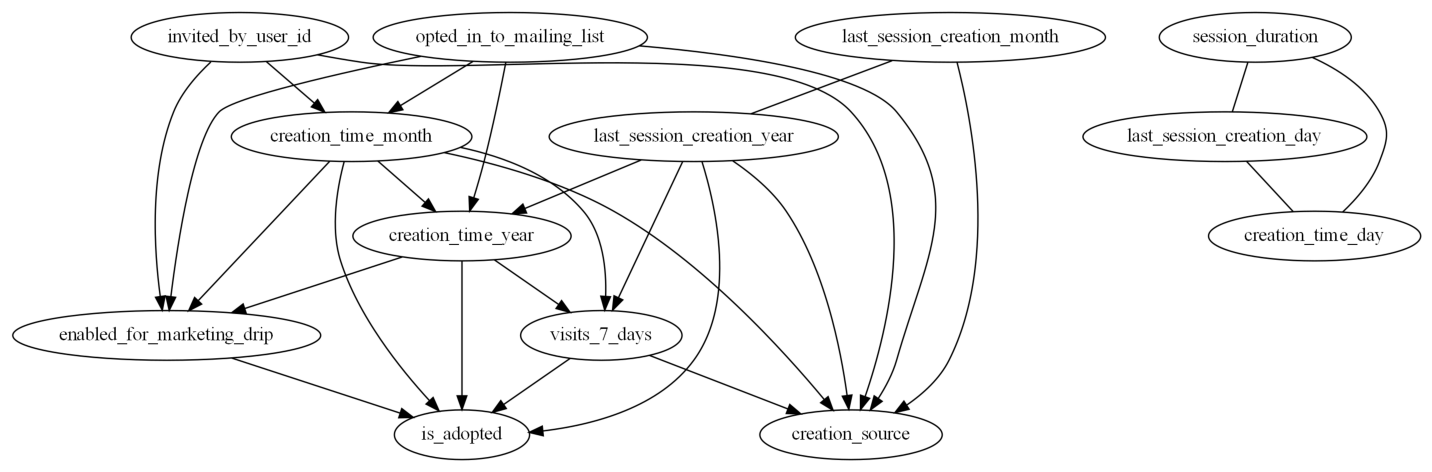

In [68]:
cg_model.draw_pydot_graph()

## Correlation Matrix

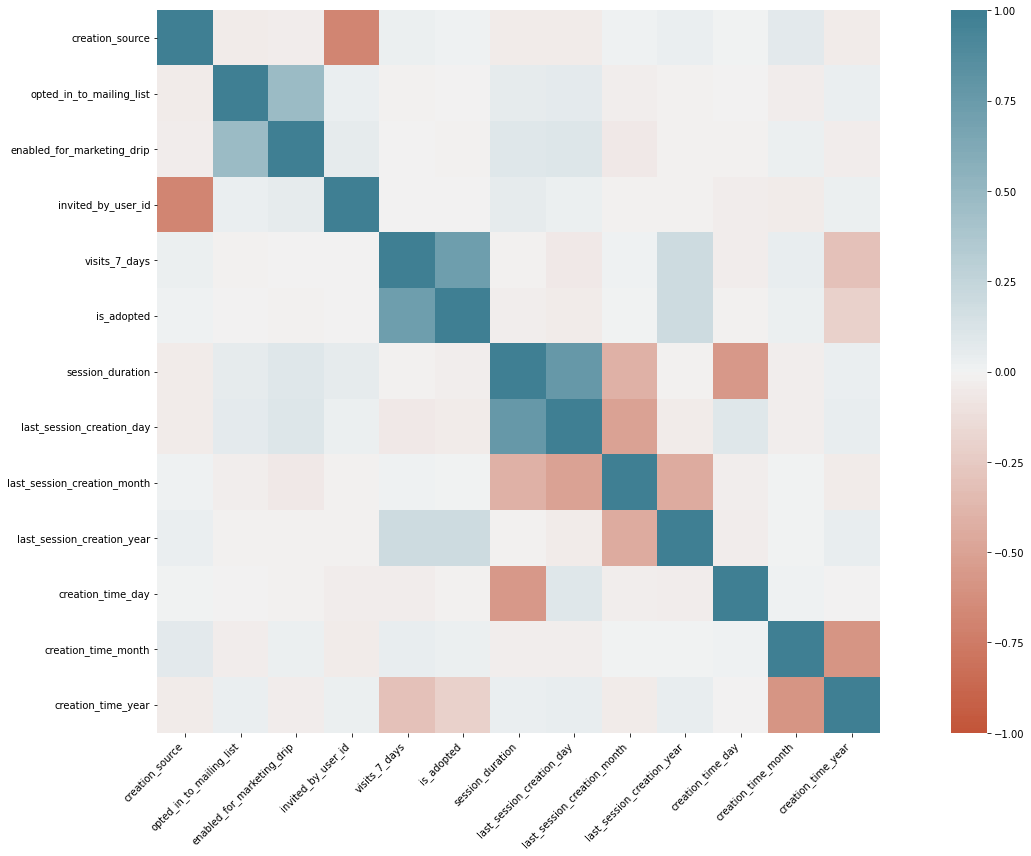

In [70]:
import seaborn as sns
corr_matrix = users_fd.corr()

corr_matrix
# corr_matrix.style.background_gradient(cmap='coolwarm')
ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [83]:
# users_fd.columns
# X_test

In [82]:
# users_fd=users_fd.drop(columns=['object_id','org_id','user_id'])
def corr_mat(df):
    corr_matrix = df.corr()
    ax = sns.heatmap(
        corr_matrix, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
# corr_mat(users_fd)

In [73]:
# users_f
import catboost
from catboost import CatBoostClassifier,Pool
from catboost.utils import get_gpu_device_count
print('\n%i GPU devices available' % get_gpu_device_count())
X = users_fd.drop(['is_adopted'],axis=1)
y = users_fd.is_adopted
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=30, stratify=y)
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=30, stratify=y)
catboost_model=CatBoostClassifier(iterations=1500,
                                  depth=10,
                                  learning_rate=0.02,
                                  eval_metric='Accuracy',
                                  loss_function='MultiClass',
                                  task_type="GPU")


catboost_model.fit(X_train.values,y_train.values,eval_set=(X_test.values,y_test.values),plot=True)


1 GPU devices available


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 63.4ms	remaining: 1m 34s
1:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 95.4ms	remaining: 1m 11s
2:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 128ms	remaining: 1m 4s
3:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 159ms	remaining: 59.4s
4:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 189ms	remaining: 56.6s
5:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 217ms	remaining: 54s
6:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 248ms	remaining: 52.9s
7:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 280ms	remaining: 52.2s
8:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 312ms	remaining: 51.7s
9:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 342ms	remaining: 50.9s
10:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 372ms	remaining: 50.4s
11:	learn: 1.0000000	test: 1.0000000	best: 1.000000

98:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.28s	remaining: 46.4s
99:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.31s	remaining: 46.3s
100:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.34s	remaining: 46.2s
101:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.36s	remaining: 46.1s
102:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.39s	remaining: 46s
103:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.42s	remaining: 45.9s
104:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.45s	remaining: 45.9s
105:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.48s	remaining: 45.8s
106:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.52s	remaining: 45.8s
107:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.54s	remaining: 45.7s
108:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 3.57s	remaining: 45.6s
109:	learn: 1.0000000	test: 1.000000

197:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.35s	remaining: 41.8s
198:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.38s	remaining: 41.7s
199:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.41s	remaining: 41.6s
200:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.43s	remaining: 41.6s
201:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.46s	remaining: 41.5s
202:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.49s	remaining: 41.5s
203:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.52s	remaining: 41.4s
204:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.56s	remaining: 41.4s
205:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.59s	remaining: 41.4s
206:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.62s	remaining: 41.4s
207:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 6.65s	remaining: 41.3s
208:	learn: 1.0000000	test: 1.00

296:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.47s	remaining: 38.4s
297:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.5s	remaining: 38.3s
298:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.53s	remaining: 38.3s
299:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.56s	remaining: 38.2s
300:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.59s	remaining: 38.2s
301:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.62s	remaining: 38.1s
302:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.65s	remaining: 38.1s
303:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.68s	remaining: 38.1s
304:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.7s	remaining: 38s
305:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.72s	remaining: 37.9s
306:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 9.75s	remaining: 37.9s
307:	learn: 1.0000000	test: 1.000000

392:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.6s	remaining: 32.5s
393:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.6s	remaining: 32.5s
394:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.6s	remaining: 32.4s
395:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.6s	remaining: 32.4s
396:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.6s	remaining: 32.3s
397:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.7s	remaining: 32.3s
398:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.7s	remaining: 32.2s
399:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.7s	remaining: 32s
400:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.7s	remaining: 32s
401:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.7s	remaining: 31.9s
402:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 11.7s	remaining: 31.8s
403:	learn: 1.0000000	test: 1.000000

493:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.8s	remaining: 26s
494:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.8s	remaining: 26s
495:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.8s	remaining: 25.9s
496:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.8s	remaining: 25.9s
497:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.8s	remaining: 25.8s
498:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.8s	remaining: 25.8s
499:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.9s	remaining: 25.7s
500:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.9s	remaining: 25.7s
501:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.9s	remaining: 25.6s
502:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.9s	remaining: 25.6s
503:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 12.9s	remaining: 25.5s
504:	learn: 1.0000000	test: 1.000000

595:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.4s	remaining: 21.8s
596:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.4s	remaining: 21.7s
597:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.4s	remaining: 21.7s
598:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.4s	remaining: 21.7s
599:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.4s	remaining: 21.6s
600:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.4s	remaining: 21.6s
601:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.4s	remaining: 21.6s
602:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.5s	remaining: 21.5s
603:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.5s	remaining: 21.5s
604:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.5s	remaining: 21.5s
605:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 14.5s	remaining: 21.4s
606:	learn: 1.0000000	test: 1.00

689:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.5s	remaining: 19.4s
690:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.5s	remaining: 19.4s
691:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.6s	remaining: 19.3s
692:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.6s	remaining: 19.3s
693:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.6s	remaining: 19.3s
694:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.6s	remaining: 19.3s
695:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.6s	remaining: 19.2s
696:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.7s	remaining: 19.2s
697:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.7s	remaining: 19.2s
698:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.7s	remaining: 19.2s
699:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 16.8s	remaining: 19.2s
700:	learn: 1.0000000	test: 1.00

783:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 18.8s	remaining: 17.2s
784:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 18.8s	remaining: 17.1s
785:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 18.8s	remaining: 17.1s
786:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 18.9s	remaining: 17.1s
787:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 18.9s	remaining: 17.1s
788:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 19s	remaining: 17.1s
789:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 19s	remaining: 17.1s
790:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 19s	remaining: 17.1s
791:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 19.1s	remaining: 17s
792:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 19.1s	remaining: 17s
793:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 19.1s	remaining: 17s
794:	learn: 1.0000000	test: 1.0000000	best: 

877:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.1s	remaining: 14.9s
878:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.1s	remaining: 14.9s
879:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.1s	remaining: 14.9s
880:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.1s	remaining: 14.9s
881:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.2s	remaining: 14.8s
882:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.2s	remaining: 14.8s
883:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.2s	remaining: 14.8s
884:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.2s	remaining: 14.8s
885:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.3s	remaining: 14.7s
886:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.3s	remaining: 14.7s
887:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 21.3s	remaining: 14.7s
888:	learn: 1.0000000	test: 1.00

974:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.4s	remaining: 12.6s
975:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.4s	remaining: 12.6s
976:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.4s	remaining: 12.5s
977:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.4s	remaining: 12.5s
978:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.5s	remaining: 12.5s
979:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.5s	remaining: 12.5s
980:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.5s	remaining: 12.4s
981:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.5s	remaining: 12.4s
982:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.6s	remaining: 12.4s
983:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.6s	remaining: 12.4s
984:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 23.6s	remaining: 12.3s
985:	learn: 1.0000000	test: 1.00

1071:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.7s	remaining: 10.2s
1072:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.7s	remaining: 10.2s
1073:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.7s	remaining: 10.2s
1074:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.7s	remaining: 10.2s
1075:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.8s	remaining: 10.2s
1076:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.8s	remaining: 10.1s
1077:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.8s	remaining: 10.1s
1078:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.8s	remaining: 10.1s
1079:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.9s	remaining: 10.1s
1080:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.9s	remaining: 10s
1081:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 25.9s	remaining: 10s
1082:	learn: 1.0000000	te

1170:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.2s	remaining: 7.91s
1171:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.2s	remaining: 7.89s
1172:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.2s	remaining: 7.87s
1173:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.3s	remaining: 7.85s
1174:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.3s	remaining: 7.83s
1175:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.3s	remaining: 7.81s
1176:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.4s	remaining: 7.78s
1177:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.4s	remaining: 7.76s
1178:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.4s	remaining: 7.74s
1179:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.4s	remaining: 7.71s
1180:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 28.5s	remaining: 7.69s
1181:	learn: 1.000000

1271:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.7s	remaining: 5.5s
1272:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.7s	remaining: 5.47s
1273:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.7s	remaining: 5.45s
1274:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.7s	remaining: 5.42s
1275:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.8s	remaining: 5.4s
1276:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.8s	remaining: 5.38s
1277:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.8s	remaining: 5.35s
1278:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.8s	remaining: 5.33s
1279:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.9s	remaining: 5.3s
1280:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.9s	remaining: 5.28s
1281:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 30.9s	remaining: 5.25s
1282:	learn: 1.0000000	t

1369:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.1s	remaining: 3.14s
1370:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.1s	remaining: 3.12s
1371:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.1s	remaining: 3.09s
1372:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.2s	remaining: 3.07s
1373:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.2s	remaining: 3.04s
1374:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.2s	remaining: 3.02s
1375:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.2s	remaining: 3s
1376:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.3s	remaining: 2.97s
1377:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.3s	remaining: 2.95s
1378:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.3s	remaining: 2.92s
1379:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 33.3s	remaining: 2.9s
1380:	learn: 1.0000000	te

1464:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.4s	remaining: 846ms
1465:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.4s	remaining: 822ms
1466:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.5s	remaining: 798ms
1467:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.5s	remaining: 773ms
1468:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.5s	remaining: 749ms
1469:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.5s	remaining: 725ms
1470:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.6s	remaining: 701ms
1471:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.6s	remaining: 677ms
1472:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.6s	remaining: 653ms
1473:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.6s	remaining: 628ms
1474:	learn: 1.0000000	test: 1.0000000	best: 1.0000000 (0)	total: 35.7s	remaining: 605ms
1475:	learn: 1.000000

In [ ]:
# https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/DoWhy-The%20Causal%20Story%20Behind%20Hotel%20Booking%20Cancellations.html
